<a href="https://colab.research.google.com/github/Barryugo/Disease-detection/blob/main/disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gdown

In [3]:
!pip install split-folders
!pip install TensorFlow

In [4]:
import os
import tensorflow as tf
import cv2, pathlib, splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive

In [5]:
from google.colab import files
import zipfile
import io

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!gdown --id 1tMMrivJDCM62PEuXHUnOG1YKH9KI6Lfv


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tMMrivJDCM62PEuXHUnOG1YKH9KI6Lfv
To: /content/archive.zip
100% 169M/169M [00:04<00:00, 40.7MB/s]


In [8]:
!unzip -uq "archive.zip" -d "Disease_detection"


In [9]:
!ls /content/Disease_detection/data


Blight	Common_Rust  Gray_Leaf_Spot  Healthy


In [10]:
epochs = 30
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)


def create_data_sparse(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='Imgs/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(rescale=1.0 / 255)
    train_ds = data_gen.flow_from_directory('Imgs/train/', target_size=(img_height, img_width),
                                            class_mode='sparse', batch_size=batch_size, subset='training')
    val_ds = data_gen.flow_from_directory('Imgs/val/', target_size=(img_height, img_width),
                                          class_mode='sparse', batch_size=batch_size, shuffle=False)

    return train_ds, val_ds

train_ds, val_ds = create_data_sparse('/content/Disease_detection/data')

Copying files: 4188 files [00:00, 5301.78 files/s]


Found 2930 images belonging to 4 classes.
Found 626 images belonging to 4 classes.


In [16]:
class BaseModel(tf.keras.Model):
    def __init__(self):
        super(BaseModel, self).__init__()

        self.C1 = Conv2D(32, (3 * 3), padding='same', input_shape = input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(2, padding='same')

        self.C2 = Conv2D(32, (3 * 3), padding='same')
        self.B2 = BatchNormalization()
        self.A2 = Activation('relu')
        self.P2 = MaxPooling2D(2, padding='same')
        self.Dr1 = Dropout(0.3)

        self.C3 = Conv2D(32, (3 * 3), padding='same')
        self.B3 = BatchNormalization()
        self.A3 = Activation('relu')
        self.P3 = MaxPooling2D(2, padding='same')
        self.Dr2 = Dropout(0.3)

        self.F1 = Flatten()
        self.D1 = Dense(256, activation='relu')
        self.B4 = BatchNormalization()
        self.D2 = Dense(256, activation='relu')
        self.D3 = Dense(256, activation='relu')
        self.D4 = Dense(256, activation='relu')
        self.Dr3 = Dropout(0.3)
        self.D5 = Dense(4, activation='softmax')


    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)

        x = self.C2(x)
        x = self.B2(x)
        x = self.A2(x)
        x = self.P2(x)
        x = self.Dr1(x)

        x = self.C3(x)
        x = self.B3(x)
        x = self.A3(x)
        x = self.P3(x)
        x = self.Dr2(x)

        x = self.F1(x)
        x = self.D1(x)
        x = self.B4(x)
        x = self.D2(x)
        x = self.D3(x)
        x = self.D4(x)
        x = self.Dr3(x)
        y = self.D5(x)

        return y

    def __repr__(self):
        name = 'Huang_Model'
        return name


net = BaseModel()

net.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = './Model.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    net.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_weights_only=True,
                                                 save_best_only=True)

history = net.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, callbacks=[cp_callback])

net.summary()

file = open('./weights.txt', 'w')
for v in net.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()

Epoch 1/30
92/92 [==============================] - 38s 347ms/step - loss: 0.0923 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.5040 - val_sparse_categorical_accuracy: 0.8706
Epoch 2/30
92/92 [==============================] - 33s 356ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0.9679 - val_loss: 2.1590 - val_sparse_categorical_accuracy: 0.6677
Epoch 3/30
92/92 [==============================] - 32s 352ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9713 - val_loss: 1.3463 - val_sparse_categorical_accuracy: 0.7396
Epoch 4/30
92/92 [==============================] - 31s 335ms/step - loss: 0.0706 - sparse_categorical_accuracy: 0.9782 - val_loss: 1.3403 - val_sparse_categorical_accuracy: 0.6534
Epoch 5/30
92/92 [==============================] - 33s 356ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9765 - val_loss: 2.4032 - val_sparse_categorical_accuracy: 0.6693
Epoch 6/30
92/92 [==============================] - 31s 341ms/step - loss: 0.0476 - sparse_cate

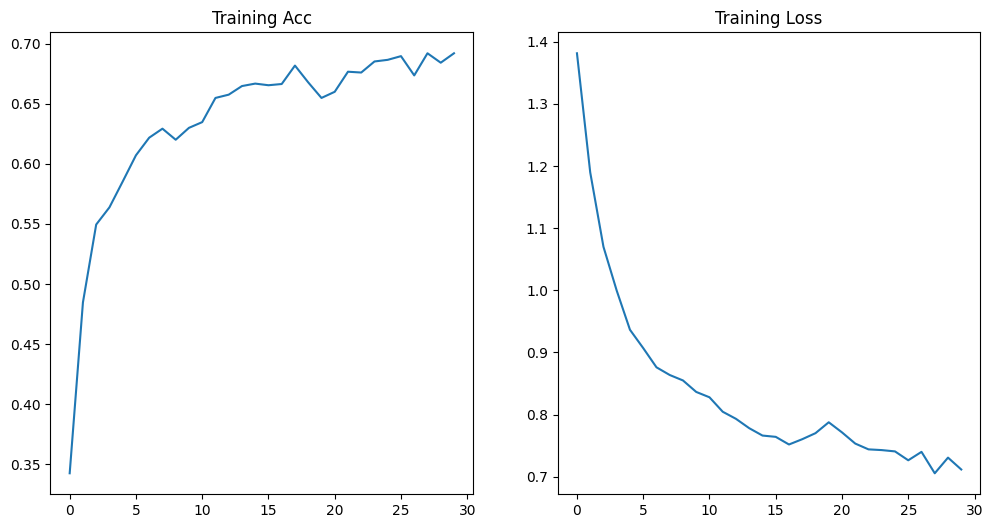

In [12]:
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

In [11]:
# import the libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import splitfolders

# set the parameters
epochs = 30
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

# create the data generator and split the dataset
data_gen = ImageDataGenerator(rescale=1.0 / 255)
splitfolders.ratio('/content/Disease_detection/data', output='Imgs/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)

# create the train and validation datasets
train_ds = data_gen.flow_from_directory('Imgs/train/', target_size=(img_height, img_width),
                                        class_mode='sparse', batch_size=batch_size, subset='training')
val_ds = data_gen.flow_from_directory('Imgs/val/', target_size=(img_height, img_width),
                                      class_mode='sparse', batch_size=batch_size, shuffle=False)

# load the pretrained model and freeze its weights
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

# create the transfer learning model
from tensorflow.keras.layers import GlobalAveragePooling2D
model_tr = Sequential()
model_tr.add(base_model)
model_tr.add(GlobalAveragePooling2D())
model_tr.add(Dense(256, activation='relu'))
model_tr.add(Dropout(0.3))
model_tr.add(Dense(4, activation='softmax'))


# compile and train the model
model_tr.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = './Model.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model_tr.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_weights_only=True,
                                                 save_best_only=True)

history = model_tr.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, callbacks=[cp_callback])

model_tr.summary()

file = open('./weights.txt', 'w')
for v in model_tr.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()


Copying files: 4188 files [00:00, 4725.30 files/s]


Found 2930 images belonging to 4 classes.
Found 626 images belonging to 4 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/30
92/92 [==============================] - 43s 327ms/step - loss: 1.3814 - sparse_categorical_accuracy: 0.3423 - val_loss: 1.2709 - val_sparse_categorical_accuracy: 0.3259
Epoch 2/30
92/92 [==============================] - 27s 297ms/step - loss: 1.1898 - sparse_categorical_accuracy: 0.4846 - val_loss: 1.0931 - val_sparse_categorical_accuracy: 0.5399
Epoch 3/30
92/92 [==============================] - 28s 299ms/step - loss: 1.0699 - sparse_categorical_accuracy: 0.5495 - val_loss: 0.9829 - val_sparse_categorical_accuracy: 0.5655
Epoch 4/30
92/92 [==============================] - 28s 304ms/step - loss: 0.9994 - sparse_categorical_accuracy: 0.5638 - val_loss: 0.9566 - val_sparse_categorical_accuracy: 0.6677
Epoch 5/30
92/92 [==============================] - 28s 305ms/step - loss: 0.9364 - sparse_categorical_accuracy: 0.5853 - val_lo

In [18]:
test_loss, test_acc = model_tr.evaluate(val_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

20/20 [==============================] - 5s 213ms/step - loss: 0.7375 - sparse_categorical_accuracy: 0.7300
Test loss: 0.7374860644340515
Test accuracy: 0.7300319671630859


In [1]:
model_tr.save('dis_det')

NameError: ignored